# **Import necessary libraries**

In [53]:
!pip install shutup #optional :>
import shutup
shutup.please()

In [54]:
!pip install nltk
!pip install pyLDAvis
!pip install WordCloud
!pip install --upgrade gensim 

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import datetime #datetime data type
from pandas.plotting import scatter_matrix
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from nltk import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline
sb.set()

[nltk_data] Downloading package punkt to /Users/zihang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zihang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
P = pd.read_csv('https://raw.githubusercontent.com/calebczh/Trump-Tweets-and-Financial-Market-Relationship/main/Datasets/combinedData.csv')
P['date'] = pd.to_datetime(P['date']) #setting date to datetime data type
P = P.set_index('date')
P

,content,retweets,favorites,mentions,hashtags,Volume,returns,wordCount
date,,,,,,,,
2017-01-22,A fantastic day and evening in Washington D.C....,19831,158502,@FoxNews,NaN,3.152710e+09,-0.002690,23
2017-01-23,Had a great meeting at CIA Headquarters yester...,14153,113013,NaN,NaN,3.810960e+09,0.006565,21
2017-01-23,Watched protests yesterday but was under the i...,38039,186835,NaN,NaN,3.810960e+09,0.006565,23
2017-01-23,"Wow, television ratings just out: 31 million p...",33675,192297,NaN,NaN,3.810960e+09,0.006565,23
2017-01-23,Peaceful protests are a hallmark of our democr...,76233,353955,NaN,NaN,3.810960e+09,0.006565,24
...,...,...,...,...,...,...,...,...
2020-06-15,…,26394,109146,NaN,NaN,5.829240e+09,0.018962,1
2020-06-15,Does anyone notice how little the Radical Left...,50321,201626,NaN,NaN,5.829240e+09,0.018962,47
2020-06-15,Interesting how ANTIFA and other Far Left mili...,69353,268924,NaN,NaN,5.829240e+09,0.018962,48


We plan to use Linear Regression to approach our problem, but in two ways:
- To predict market performance with most commonly used words(excluding stop words) by Donald Trump
- To predict market performance with the topics related to by the tweet of Donald Trump


To be able to perform the former, we will need to generate the topics in his tweets via Natural Language Processing

# Natural Language Processing
Below lists out the steps in how we generate the topics.
- Text prepossessing
    - Tokenization
    - N-grams 
    - Stop words filtering 
    - Stemming
- Latent Dirichlet Allocation
    - Create the Dictionary and Corpus needed for Topic Modeling
    - Building the Topic Model
        - View the topics in LDA model
        - Compute Model Perplexity and Coherence Score
        - Choose the most suitable numbe rof topics to generate
    - Visualize the topics-keywords

## Text prepossessing

In [56]:
porter = PorterStemmer()

#removing non-alphabets
def onlyAlpha(text):
    new_text = ''.join(ch.lower() for ch in text if ch.isalnum() or ch.isspace()) 
    return new_text

#removing ngrams containing any stop words
def bigram(text, n):
    token = word_tokenize(text)
    bigram = list(ngrams(token, n)) #n-gram
    clean = [gram for gram in bigram if not any(stop in gram for stop in sw_nltk)] 
    new_lst = ' '.join('_'.join(t) for t in clean)
    return new_lst

#removing stop words
def process(text): 
    words = [(porter.stem(word)) for word in text.split() if word.lower() not in sw_nltk] 
    new_text = " ".join(words)
    return new_text

def deepClean(text): 
    words = [word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS] 
    new_text = " ".join(words)
    return new_text

def replaceTweet(to_replace, words):
    for word in words:
        to_replace = to_replace.replace(word, word.replace(" ", "_"))
    return to_replace

In [57]:
P['content'] = P['content'].map(lambda x: onlyAlpha(x))
P

,content,retweets,favorites,mentions,hashtags,Volume,returns,wordCount
date,,,,,,,,
2017-01-22,a fantastic day and evening in washington dcth...,19831,158502,@FoxNews,NaN,3.152710e+09,-0.002690,23
2017-01-23,had a great meeting at cia headquarters yester...,14153,113013,NaN,NaN,3.810960e+09,0.006565,21
2017-01-23,watched protests yesterday but was under the i...,38039,186835,NaN,NaN,3.810960e+09,0.006565,23
2017-01-23,wow television ratings just out 31 million peo...,33675,192297,NaN,NaN,3.810960e+09,0.006565,23
2017-01-23,peaceful protests are a hallmark of our democr...,76233,353955,NaN,NaN,3.810960e+09,0.006565,24
...,...,...,...,...,...,...,...,...
2020-06-15,,26394,109146,NaN,NaN,5.829240e+09,0.018962,1
2020-06-15,does anyone notice how little the radical left...,50321,201626,NaN,NaN,5.829240e+09,0.018962,47
2020-06-15,interesting how antifa and other far left mili...,69353,268924,NaN,NaN,5.829240e+09,0.018962,48


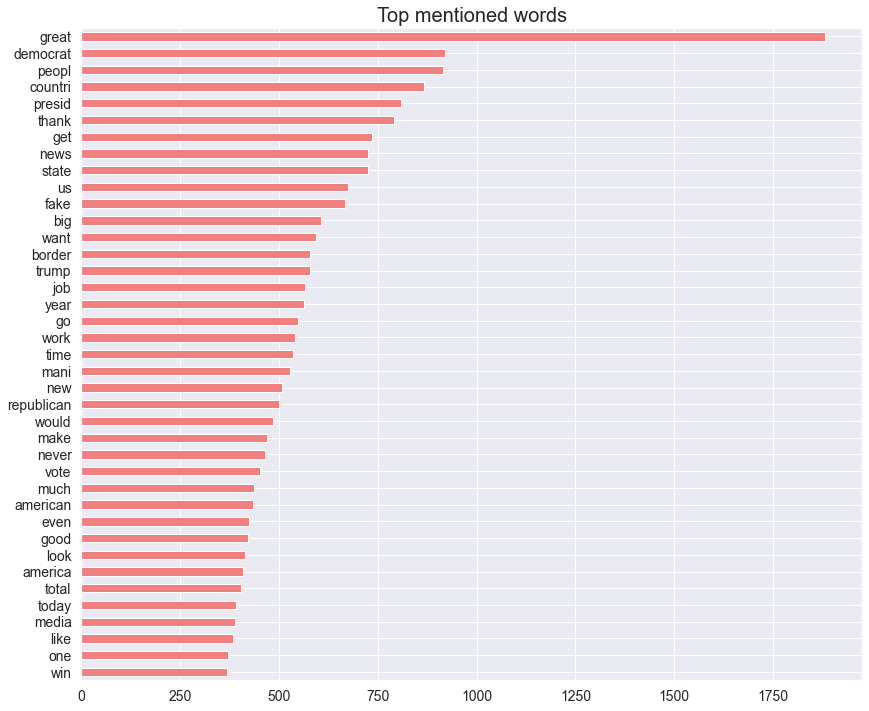

In [58]:
P['single'] = P['content'].map(lambda x: process(x))  #tokenization, dorrping stopwords and PorterStemming
a = [word for tweet in P["single"] for word in tweet.split()]
pd.Series(a).value_counts()[0:39].plot.barh(figsize=(14, 12), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned words', fontsize=20)
plt.gca().invert_yaxis()

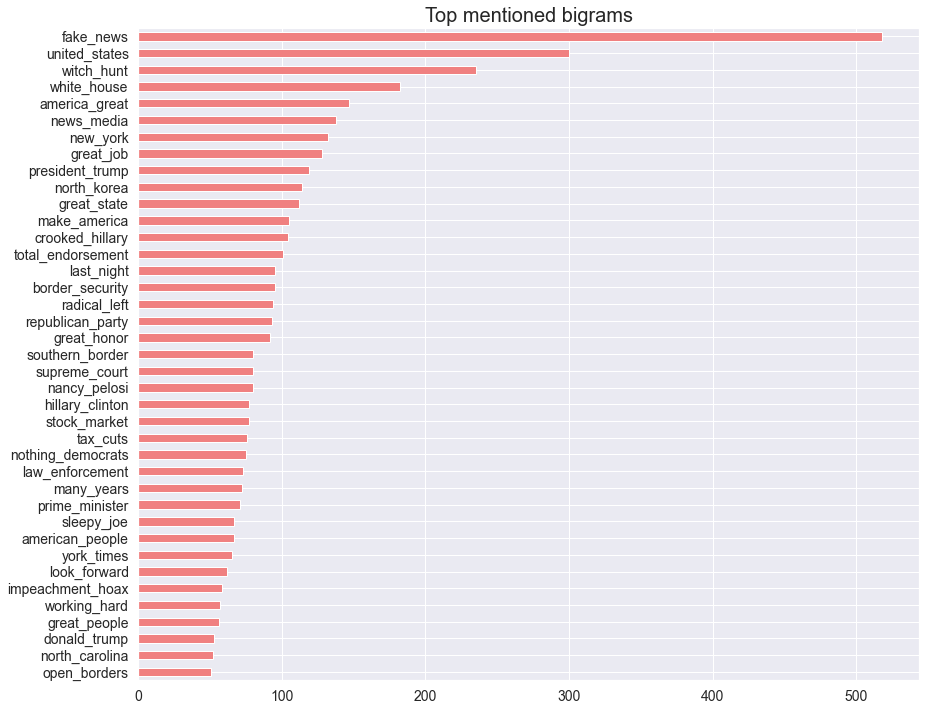

In [59]:
wordBag =[]
P['bigram'] = P['content'].map(lambda x: bigram(x, 2) )
a = [word for tweet in P["bigram"] for word in tweet.split()]
pd.Series(a).value_counts()[0:39].plot.barh(figsize=(14, 12), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned bigrams', fontsize=20)
plt.gca().invert_yaxis()
wordBag = pd.Series(a).value_counts().index[:400].tolist()

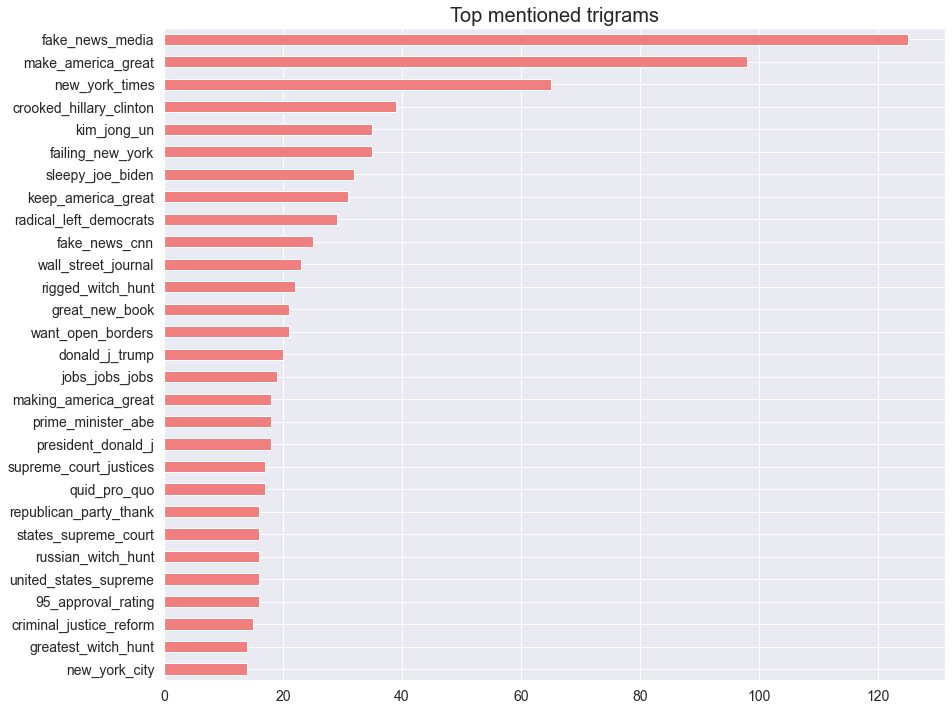

In [60]:
P['trigram'] = P['content'].map(lambda x: bigram(x, 3) )
a = [word for tweet in P["trigram"] for word in tweet.split()]
pd.Series(a).value_counts()[0:29].plot.barh(figsize=(14, 12), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned trigrams', fontsize=20)
plt.gca().invert_yaxis()
wordBag += pd.Series(a).value_counts().index[:100].tolist()

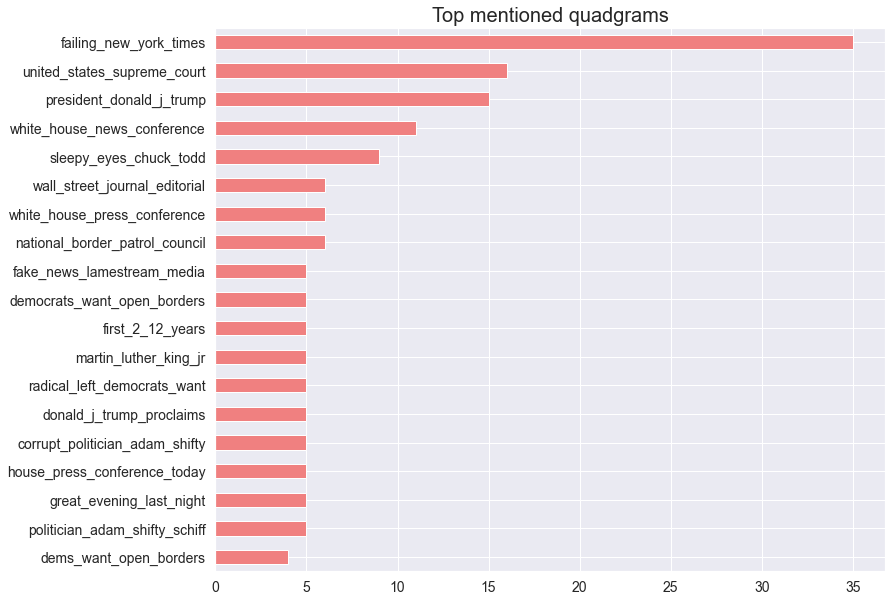

In [61]:
P['quadgram'] = P['content'].map(lambda x: bigram(x, 4) )
a = [word for tweet in P['quadgram'] for word in tweet.split()]
pd.Series(a).value_counts()[0:19].plot.barh(figsize=(12, 10), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned quadgrams', fontsize=20)
plt.gca().invert_yaxis()
wordBag += pd.Series(a).value_counts().index[:19].tolist()

In [62]:
processedWordBag =[]
for word in wordBag:
    word = word.replace("_", " ")
    processedWordBag.append(word)
    
processedWordBag = processedWordBag[::-1] #reverse to prioritise quad over tri over bi
processedWordBag

['dems want open borders',
 'politician adam shifty schiff',
 'great evening last night',
 'house press conference today',
 'corrupt politician adam shifty',
 'donald j trump proclaims',
 'radical left democrats want',
 'martin luther king jr',
 'first 2 12 years',
 'democrats want open borders',
 'fake news lamestream media',
 'national border patrol council',
 'white house press conference',
 'wall street journal editorial',
 'sleepy eyes chuck todd',
 'white house news conference',
 'president donald j trump',
 'united states supreme court',
 'failing new york times',
 'big crowd expected',
 'united states congress',
 'martin luther king',
 'psycho joe scarborough',
 'russia witch hunt',
 'keep america safe',
 'pastor andrew brunson',
 'new york state',
 '17 angry democrats',
 'want border security',
 'frame donald trump',
 'joint press conference',
 'press conference today',
 'welcome prime minister',
 'border patrol council',
 'supreme court justice',
 'house press conference',
 '

In [63]:
P['single'] = P['single'].map(lambda x: replaceTweet(x, processedWordBag))
P['single']

date
2017-01-22    fantast day even washington_dcthank mani news ...
2017-01-23    great meet cia headquart yesterday pack hous p...
2017-01-23    watch protest yesterday impress elect didnt pe...
2017-01-23    wow televis rate 31 million peopl watch inaugu...
2017-01-23    peac protest hallmark democraci even dont alwa...
                                    ...                        
2020-06-15                                                     
2020-06-15    anyon notic littl radic left takeov seattl dis...
2020-06-15    interest antifa far left milit group take citi...
2020-06-15                           silent major stronger ever
2020-06-15    mani democrat want defund abolish polic depart...
Name: single, Length: 7877, dtype: object

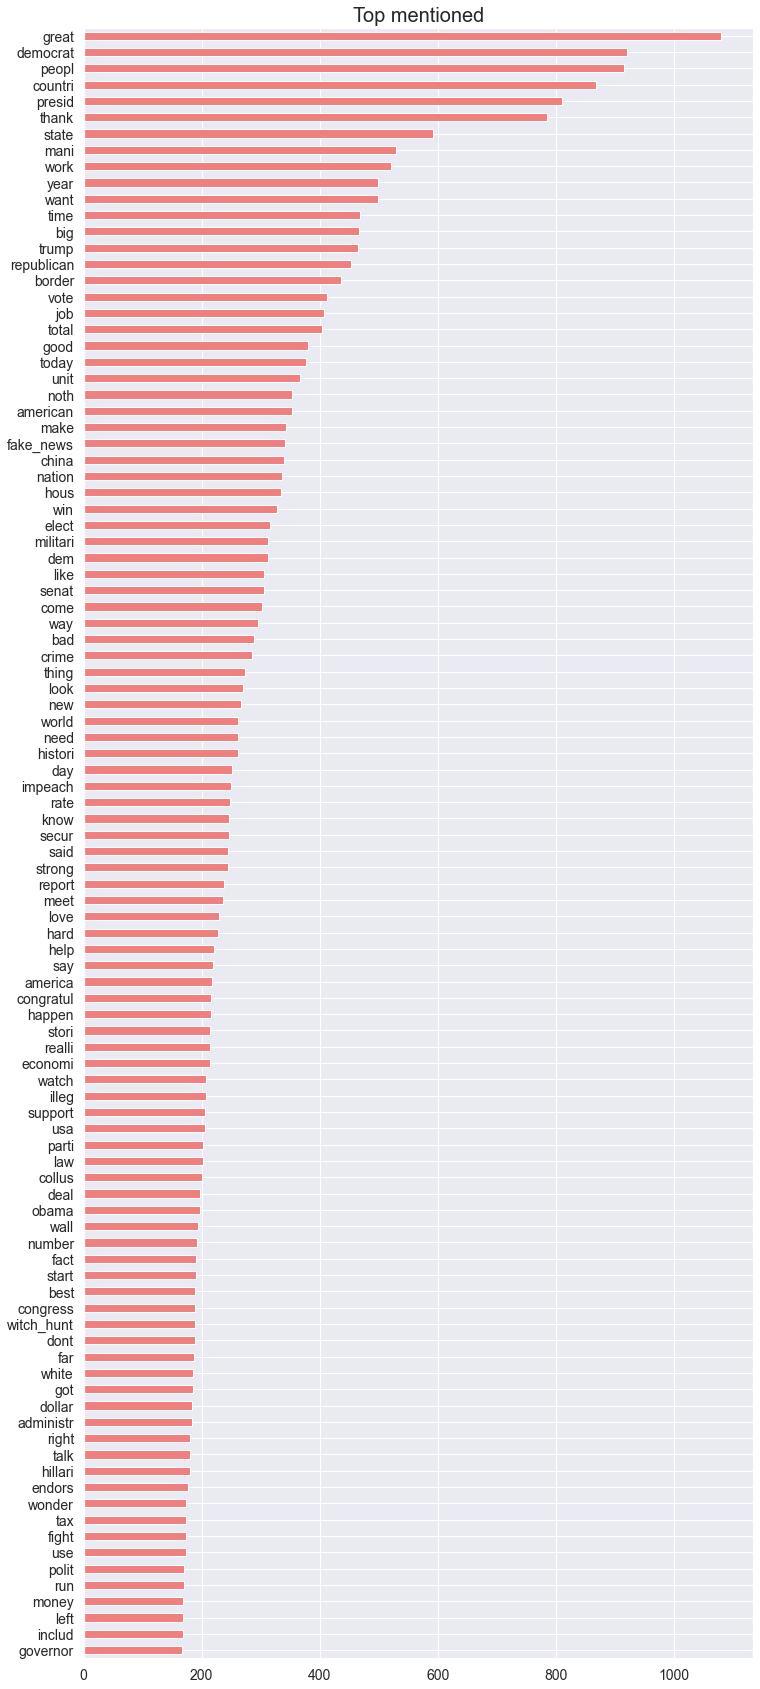

In [64]:
P['single'] = P['single'].map(lambda x: deepClean(x))
a = [word for tweet in P['single'] for word in tweet.split()]
pd.Series(a).value_counts()[0:100].plot.barh(figsize=(12, 30), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned', fontsize=20)
plt.gca().invert_yaxis()

### Topic Generation with Latent Dirichlet Allocation (LDA)

In [65]:
data_lemmatized = []
for singles in P['single']:
    data_lemmatized.append(singles.split())
data_lemmatized

[['fantast',
  'day',
  'washington_dcthank',
  'mani',
  'news',
  'outlet',
  'great',
  'review',
  'speech'],
 ['great',
  'meet',
  'cia',
  'headquart',
  'yesterday',
  'pack',
  'hous',
  'paid',
  'great',
  'respect',
  'wall',
  'long',
  'stand',
  'ovat',
  'amaz',
  'peopl',
  'win'],
 ['watch',
  'protest',
  'yesterday',
  'impress',
  'elect',
  'didnt',
  'peopl',
  'vote',
  'celeb',
  'hurt',
  'caus',
  'badli'],
 ['wow',
  'televis',
  'rate',
  '31',
  'million',
  'peopl',
  'watch',
  'inaugur',
  '11',
  'million',
  'good',
  'rate',
  '4',
  'year',
  'ago'],
 ['peac',
  'protest',
  'hallmark',
  'democraci',
  'dont',
  'alway',
  'agre',
  'recogn',
  'right',
  'peopl',
  'express',
  'view'],
 ['busi',
  'week',
  'plan',
  'heavi',
  'focu',
  'job',
  'nation',
  'secur',
  'execut',
  'come',
  '900',
  'talk',
  'manufactur',
  'america'],
 ['meet',
  '900',
  'automobil',
  'execut',
  'concern',
  'job',
  'america',
  'want',
  'new',
  'plant',


In [66]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

corpus[1]

[(2, 2),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1)]

In [67]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('day', 1),
  ('fantast', 1),
  ('great', 1),
  ('mani', 1),
  ('news', 1),
  ('outlet', 1),
  ('review', 1),
  ('speech', 1),
  ('washington_dcthank', 1)]]

In [68]:
# perplexityScore = []
# coherenceScore =[]
# for i in range(10,61):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=i, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
#     print(i)
#     # Compute Perplexity
#     a = lda_model.log_perplexity(corpus)
#     perplexityScore.append(a)
#     print('Perplexity: ', a)  # a measure of how good the model is. lower the better.

#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherenceScore.append(coherence_lda)
#     print('Coherence Score: ', coherence_lda, '\n\n')

#scores generated from the abopve loop, which takes more than 30 mins.

perplexityScore = [-8.67435892190684, -8.949908623126008, -9.401002707670074, -10.234506313068998,
                 -11.557515230173202, -13.304982565906126, -15.043886019364754, -16.825827302915314,
                 -17.657455492976737, -18.226746332439166, -18.759779830945583, -19.31464558615281,
                 -19.871225272223427, -20.408741954696666, -20.986711473291173, -21.58265823127238,
                 -22.08475647956361, -22.634517323783417, -23.196903455663403, -23.76922730826245,
                 -24.39979944728662, -24.939489580848246, -25.520322558227843, -25.99717633243492, 
                 -26.62503699724507, -27.125262789878153, -27.710082291617965, -28.328215615850205,
                 -28.79714761818389, -29.45160792750456, -29.95415302860342, -30.565806613250633,
                 -31.08010340939262, -31.6405575731801, -32.21035655173436, -32.7734338843532,
                 -33.28292745679972, -33.93414668965281, -34.48843219011082, -35.01971511829145,
                 -35.538441220680824, -36.151204072079175, -36.75891705630437, -37.28991016450194,
                 -37.86251481010597, -38.49836470651771, -39.02629686504276, -39.56741740952853,
                 -40.095370788470845, -40.74395973145286,  -41.23486375142542]

coherenceScore = [0.32457395465368966, 0.318701925121902, 0.31900952772525687, 0.32128052781085586,
                 0.301074831868324, 0.3322117164640483, 0.3339575890776156, 0.34224809313774895,
                 0.3363379830197274, 0.33848563040039875, 0.34125010959082847, 0.33481463382230275,
                 0.3470121175430418, 0.3431391382074688, 0.3314945877806477, 0.34744725345620714,
                 0.3394807453951442, 0.3523831536889826, 0.3464479853551416, 0.37094803930942705,
                 0.4962734676131974, 0.5098146439539119, 0.5082237570102692, 0.5217018815961085,
                 0.5393622005863711, 0.5319818319586936, 0.537210189827039, 0.5406104792617438,
                 0.5311009127408624, 0.5621276041237325, 0.5665196160727529, 0.5656671185246326,
                 0.5573893549813544, 0.5678772142288817, 0.5839257780347293, 0.5799130585229462,
                 0.5767830479185178, 0.5686204746884498, 0.5757545680632846, 0.5926183439052225,
                 0.5858279763213556, 0.5905512969583323, 0.5850520457032689, 0.590473469653269,
                 0.5968791760848947, 0.5860899698277207, 0.6002851009805681, 0.59751073595964,
                 0.5850929976327883, 0.5738198105938506, 0.5932422004847151]
for i in range(10,61):
    print(i)
    print('Perplexity: ', perplexityScore[i-10])
    print('Coherence Score: ', coherenceScore[i-10], '\n\n')

10
Perplexity:  -8.67435892190684
Coherence Score:  0.32457395465368966 


11
Perplexity:  -8.949908623126008
Coherence Score:  0.318701925121902 


12
Perplexity:  -9.401002707670074
Coherence Score:  0.31900952772525687 


13
Perplexity:  -10.234506313068998
Coherence Score:  0.32128052781085586 


14
Perplexity:  -11.557515230173202
Coherence Score:  0.301074831868324 


15
Perplexity:  -13.304982565906126
Coherence Score:  0.3322117164640483 


16
Perplexity:  -15.043886019364754
Coherence Score:  0.3339575890776156 


17
Perplexity:  -16.825827302915314
Coherence Score:  0.34224809313774895 


18
Perplexity:  -17.657455492976737
Coherence Score:  0.3363379830197274 


19
Perplexity:  -18.226746332439166
Coherence Score:  0.33848563040039875 


20
Perplexity:  -18.759779830945583
Coherence Score:  0.34125010959082847 


21
Perplexity:  -19.31464558615281
Coherence Score:  0.33481463382230275 


22
Perplexity:  -19.871225272223427
Coherence Score:  0.3470121175430418 


23
Perplexit

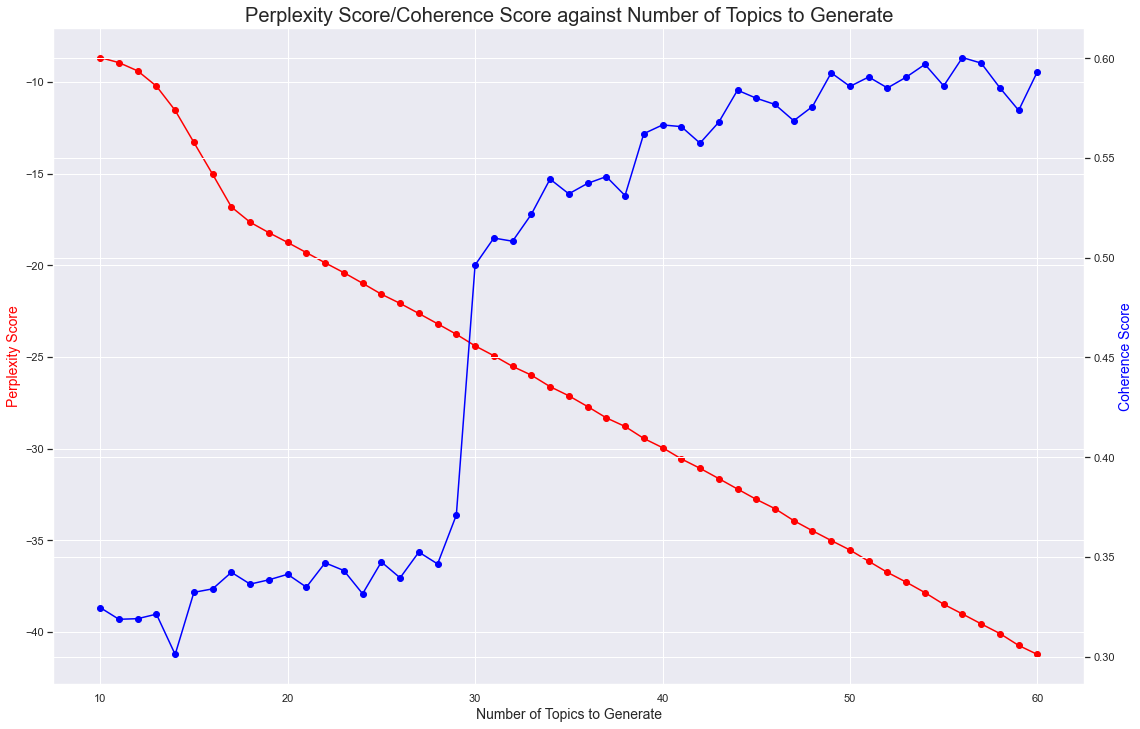

In [69]:
fig,ax = plt.subplots(figsize=(16, 10))
index = [i for i in range(10,61)]

ax.plot(index, perplexityScore, color="red", marker="o")
ax.set_xlabel("Number of Topics to Generate",fontsize=14)
ax.set_ylabel("Perplexity Score",color="red",fontsize=14)


ax2=ax.twinx()
ax2.plot(index, coherenceScore,color="blue",marker="o")
ax2.set_ylabel("Coherence Score",color="blue",fontsize=14)
fig.tight_layout()
plt.gca().set_title('Perplexity Score/Coherence Score against Number of Topics to Generate', fontsize=20)
plt.show()

In [70]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=34, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.000*"smith" + 0.000*"prudent" + 0.000*"cole" + 0.000*"jamal" + '
  '0.000*"qaeda" + 0.000*"obtrus" + 0.000*"chart" + 0.000*"inclus" + '
  '0.000*"glypti" + 0.000*"outcom"'),
 (31,
  '0.131*"death" + 0.000*"chart" + 0.000*"albadawi" + 0.000*"cole" + '
  '0.000*"jamal" + 0.000*"qaeda" + 0.000*"obtrus" + 0.000*"prudent" + '
  '0.000*"smith" + 0.000*"glypti"'),
 (24,
  '0.119*"pm" + 0.087*"line" + 0.082*"refus" + 0.077*"fox" + 0.048*"leav" + '
  '0.046*"prior" + 0.044*"florida" + 0.035*"mention" + 0.026*"big_crowd" + '
  '0.014*"network"'),
 (13,
  '0.241*"great_job" + 0.204*"congratul" + 0.094*"morn" + 0.094*"repres" + '
  '0.030*"sunday" + 0.000*"900_pm_eastern" + 0.000*"qaeda" + 0.000*"obtrus" + '
  '0.000*"chart" + 0.000*"smith"'),
 (22,
  '0.252*"vet" + 0.126*"order" + 0.125*"tonight" + 0.087*"interview" + '
  '0.056*"enjoy" + 0.027*"recent" + 0.021*"execut" + 0.004*"regard" + '
  '0.004*"extrem" + 0.000*"obtrus"'),
 (6,
  '0.105*"campaign" + 0.104*"sign" + 0.097*"nice" + 0.

In [71]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.358383 -0.325360       1        1  5.606068
33     0.472613  0.064934       2        1  5.551106
27    -0.025127  0.468634       3        1  5.171701
7      0.435619 -0.164090       4        1  4.807852
26     0.280288 -0.361751       5        1  4.551649
3     -0.445947  0.176533       6        1  4.389263
8     -0.411987 -0.179506       7        1  4.216911
20     0.139864  0.424098       8        1  4.179212
32     0.268070  0.345980       9        1  3.890666
16    -0.291435  0.310050      10        1  3.833966
28    -0.183093  0.375494      11        1  3.811588
5      0.146301 -0.378695      12        1  3.695607
25     0.380964  0.199094      13        1  3.611242
19    -0.202403 -0.359811      14        1  3.542148
4     -0.001262 -0.448621      15        1  3.408655
17    -0.411510 -0.024282      16        1  3.143141
1     -0.268010 -0.175765      17        1  3.074247
14    -0.311912  0.158595      18        1  2.870517
2      0.265973 -0.212539      19        1  2.801679
18    -0.090820 -0.332710      20        1  2.761008
29     0.349822 -0.036853      21        1  2.616182
12     0.046470 -0.291565      22        1  2.563798
10    -0.272498  0.012304      23        1  2.507796
23    -0.063578  0.303408      24        1  2.214000
30     0.247867  0.197589      25        1  2.192124
21     0.178761 -0.123244      26        1  1.602978
15     0.059404  0.258287      27        1  1.483667
6      0.181896  0.012654      28        1  1.352334
9     -0.057290 -0.140987      29        1  1.346340
22    -0.135166  0.127360      30        1  1.203915
13     0.104357  0.109928      31        1  1.008320
24    -0.059818  0.030903      32        1  0.874985
31     0.013737 -0.014005      33        1  0.075399
0      0.018230 -0.006061      34        1  0.039936, topic_info=         Term         Freq        Total Category  logprob  loglift
2       great  2280.000000  2280.000000  Default   30.000  30.0000
83      thank  2035.000000  2035.000000  Default   29.000  29.0000
287  democrat  1854.000000  1854.000000  Default   28.000  28.0000
18      peopl  1895.000000  1895.000000  Default   27.000  27.0000
213   countri  1541.000000  1541.000000  Default   26.000  26.0000
..        ...          ...          ...      ...      ...      ...
24      badli     0.004943   234.576367  Topic34   -9.069  -2.9420
25       caus     0.004943    70.373733  Topic34   -9.069  -1.7380
27      didnt     0.004943   312.694767  Topic34   -9.069  -3.2294
28      elect     0.004943   490.763338  Topic34   -9.069  -3.6801
29       hurt     0.004943   103.320809  Topic34   -9.069  -2.1220

[1508 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
446       5  0.977747          1
156      16  0.977868         10
498      16  0.402791      10000
34        3  0.909610         11
481       1  0.660821         16
...     ...       ...        ...
43       27  0.980534        wow
433       8  0.968096      write
181       8  0.994381      wrong
44        3  0.997487       year
23        7  0.979168  yesterday

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 34, 28, 8, 27, 4, 9, 21, 33, 17, 29, 6, 26, 20, 5, 18, 2, 15, 3, 19, 30, 13, 11, 24, 31, 22, 16, 7, 10, 23, 14, 25, 32, 1])

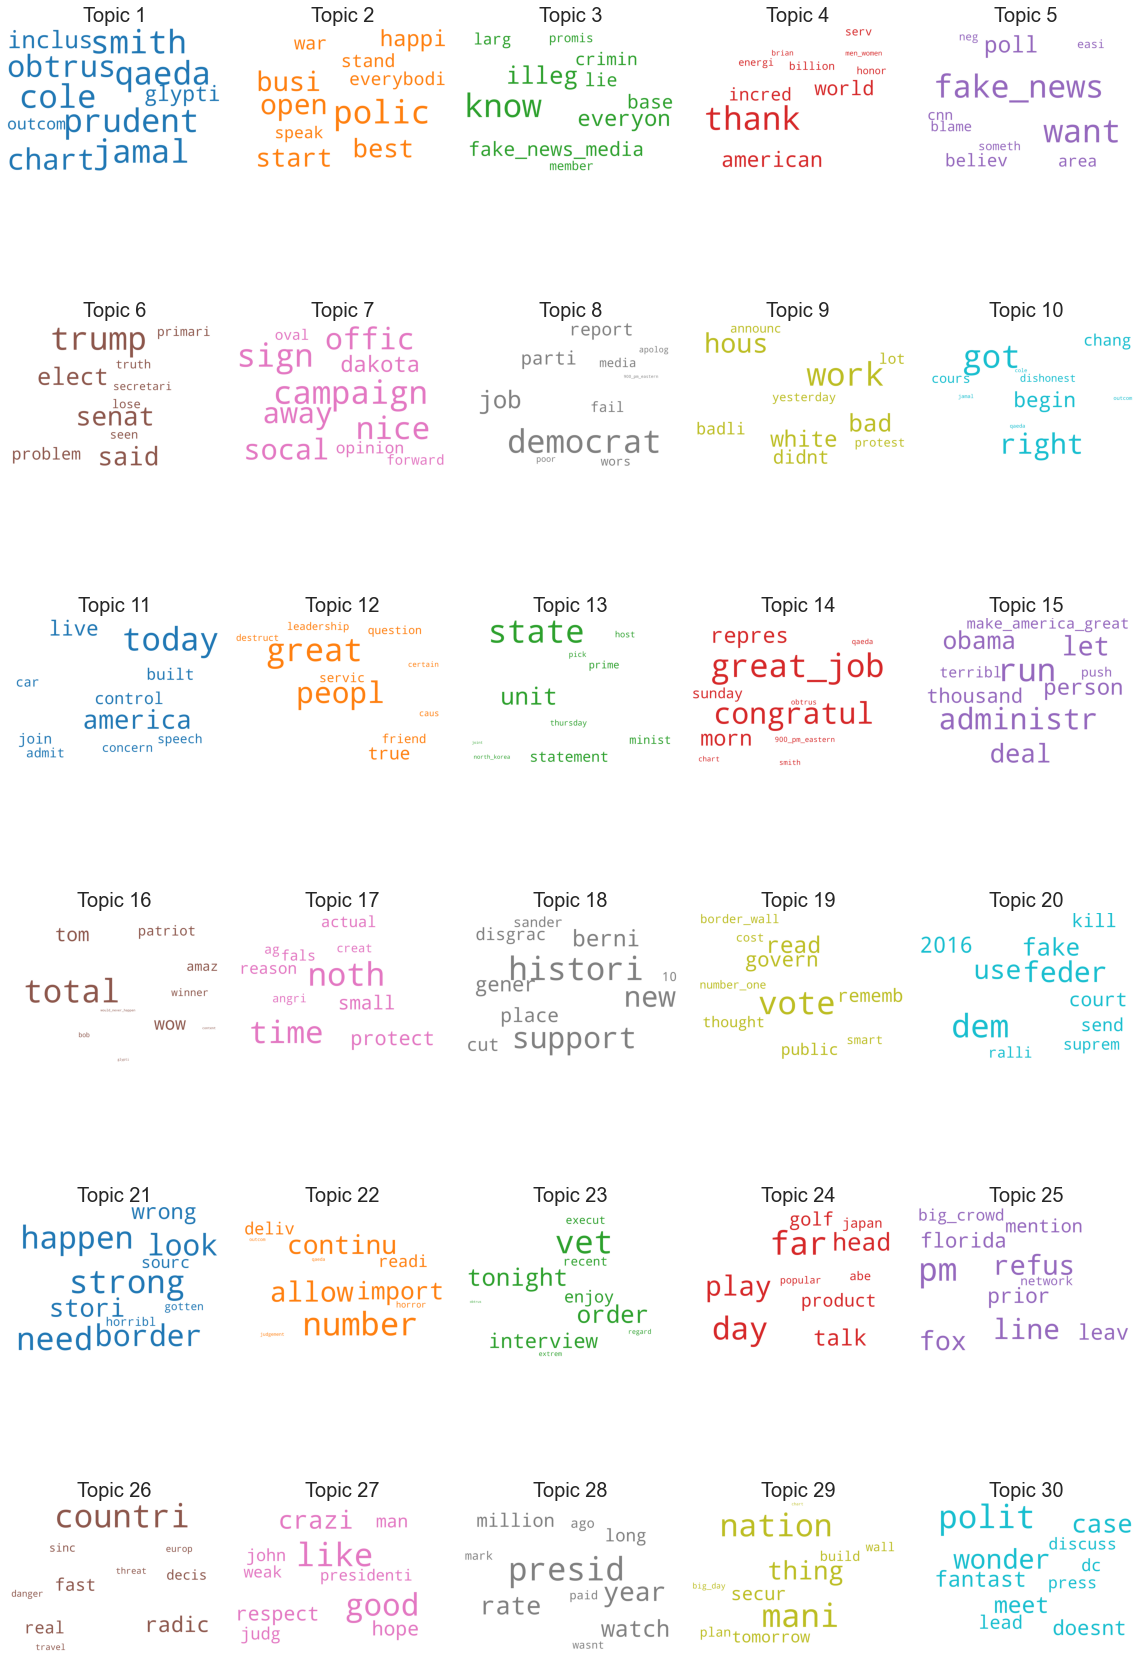

In [89]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
for name, color in mcolors.TABLEAU_COLORS.items():
    cols.append(color)
for name, color in mcolors.TABLEAU_COLORS.items():
    cols.append(color)
for name, color in mcolors.TABLEAU_COLORS.items():
    cols.append(color)
for name, color in mcolors.TABLEAU_COLORS.items():
    cols.append(color)
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2000,
                  height=1400,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics = 34, formatted=False)

fig, axes = plt.subplots(6, 5, figsize=(16,26), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [74]:
P = P.drop(['bigram', 'trigram','quadgram'], axis = 1)

# **Linear Regression**

In [75]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [90]:
#for easier visualisation, we will multiply the values of returns by 1000
P['returns'] = P['returns'] *1000
P

,content,retweets,favorites,mentions,hashtags,Volume,returns,wordCount,single,great,democrat,republican,fake_news,border,china,make_america_great
date,,,,,,,,,,,,,,,,
2017-01-22,a fantastic day and evening in washington dcth...,19831,158502,@FoxNews,NaN,3.152710e+09,-2.690125,23,fantast day washington_dcthank mani news outle...,1,0,0,0,0,0,0
2017-01-23,had a great meeting at cia headquarters yester...,14153,113013,NaN,NaN,3.810960e+09,6.564594,21,great meet cia headquart yesterday pack hous p...,1,0,0,0,0,0,0
2017-01-23,watched protests yesterday but was under the i...,38039,186835,NaN,NaN,3.810960e+09,6.564594,23,watch protest yesterday impress elect didnt pe...,0,0,0,0,0,0,0
2017-01-23,wow television ratings just out 31 million peo...,33675,192297,NaN,NaN,3.810960e+09,6.564594,23,wow televis rate 31 million peopl watch inaugu...,0,0,0,0,0,0,0
2017-01-23,peaceful protests are a hallmark of our democr...,76233,353955,NaN,NaN,3.810960e+09,6.564594,24,peac protest hallmark democraci dont alway agr...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-15,,26394,109146,NaN,NaN,5.829240e+09,18.962398,1,,0,0,0,0,0,0,0
2020-06-15,does anyone notice how little the radical left...,50321,201626,NaN,NaN,5.829240e+09,18.962398,47,anyon notic littl radic left takeov seattl dis...,0,0,0,1,0,0,0
2020-06-15,interesting how antifa and other far left mili...,69353,268924,NaN,NaN,5.829240e+09,18.962398,48,antifa far left milit group citi bare wimpier ...,0,1,0,0,0,0,0


### LinReg with most commonly used words by Donald Trump (excluding stop words)

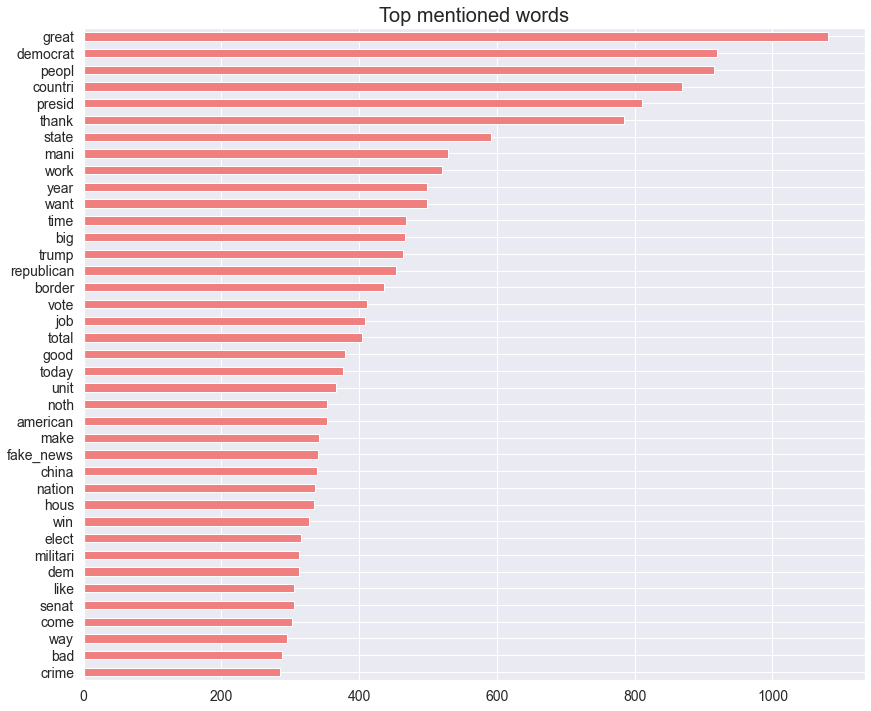

In [76]:
a = [word for tweet in P["single"] for word in tweet.split()]
pd.Series(a).value_counts()[0:39].plot.barh(figsize=(14, 12), fontsize=14, color='lightcoral')
plt.gca().set_title('Top mentioned words', fontsize=20)
plt.gca().invert_yaxis()

In [83]:
wordlist = ['great', 'democrat', 'republican', 'fake_news', ' border', 'china', 'make_america_great']
for word in wordlist:
    P[word] = 0
    for i in range(len(P)):
        if word in P.iloc[i,P.columns.get_loc('single')]:
            P.iloc[i, P.columns.get_loc(word)] = 1
P   
# sb.boxplot(data = data['returns'], orient = "h", ax = axes[count,0])
# sb.histplot(data = data['returns'], ax = axes[count,1]).set(title=("returns for tweets containing "+ var))
# sb.violinplot(data = data['returns'], orient = "h", ax = axes[count,2])
# count += 1

,content,retweets,favorites,mentions,hashtags,Volume,returns,wordCount,single,great,democrat,republican,fake_news,border,china,make_america_great
date,,,,,,,,,,,,,,,,
2017-01-22,a fantastic day and evening in washington dcth...,19831,158502,@FoxNews,NaN,3.152710e+09,-0.002690,23,fantast day washington_dcthank mani news outle...,1,0,0,0,0,0,0
2017-01-23,had a great meeting at cia headquarters yester...,14153,113013,NaN,NaN,3.810960e+09,0.006565,21,great meet cia headquart yesterday pack hous p...,1,0,0,0,0,0,0
2017-01-23,watched protests yesterday but was under the i...,38039,186835,NaN,NaN,3.810960e+09,0.006565,23,watch protest yesterday impress elect didnt pe...,0,0,0,0,0,0,0
2017-01-23,wow television ratings just out 31 million peo...,33675,192297,NaN,NaN,3.810960e+09,0.006565,23,wow televis rate 31 million peopl watch inaugu...,0,0,0,0,0,0,0
2017-01-23,peaceful protests are a hallmark of our democr...,76233,353955,NaN,NaN,3.810960e+09,0.006565,24,peac protest hallmark democraci dont alway agr...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-15,,26394,109146,NaN,NaN,5.829240e+09,0.018962,1,,0,0,0,0,0,0,0
2020-06-15,does anyone notice how little the radical left...,50321,201626,NaN,NaN,5.829240e+09,0.018962,47,anyon notic littl radic left takeov seattl dis...,0,0,0,1,0,0,0
2020-06-15,interesting how antifa and other far left mili...,69353,268924,NaN,NaN,5.829240e+09,0.018962,48,antifa far left milit group citi bare wimpier ...,0,1,0,0,0,0,0


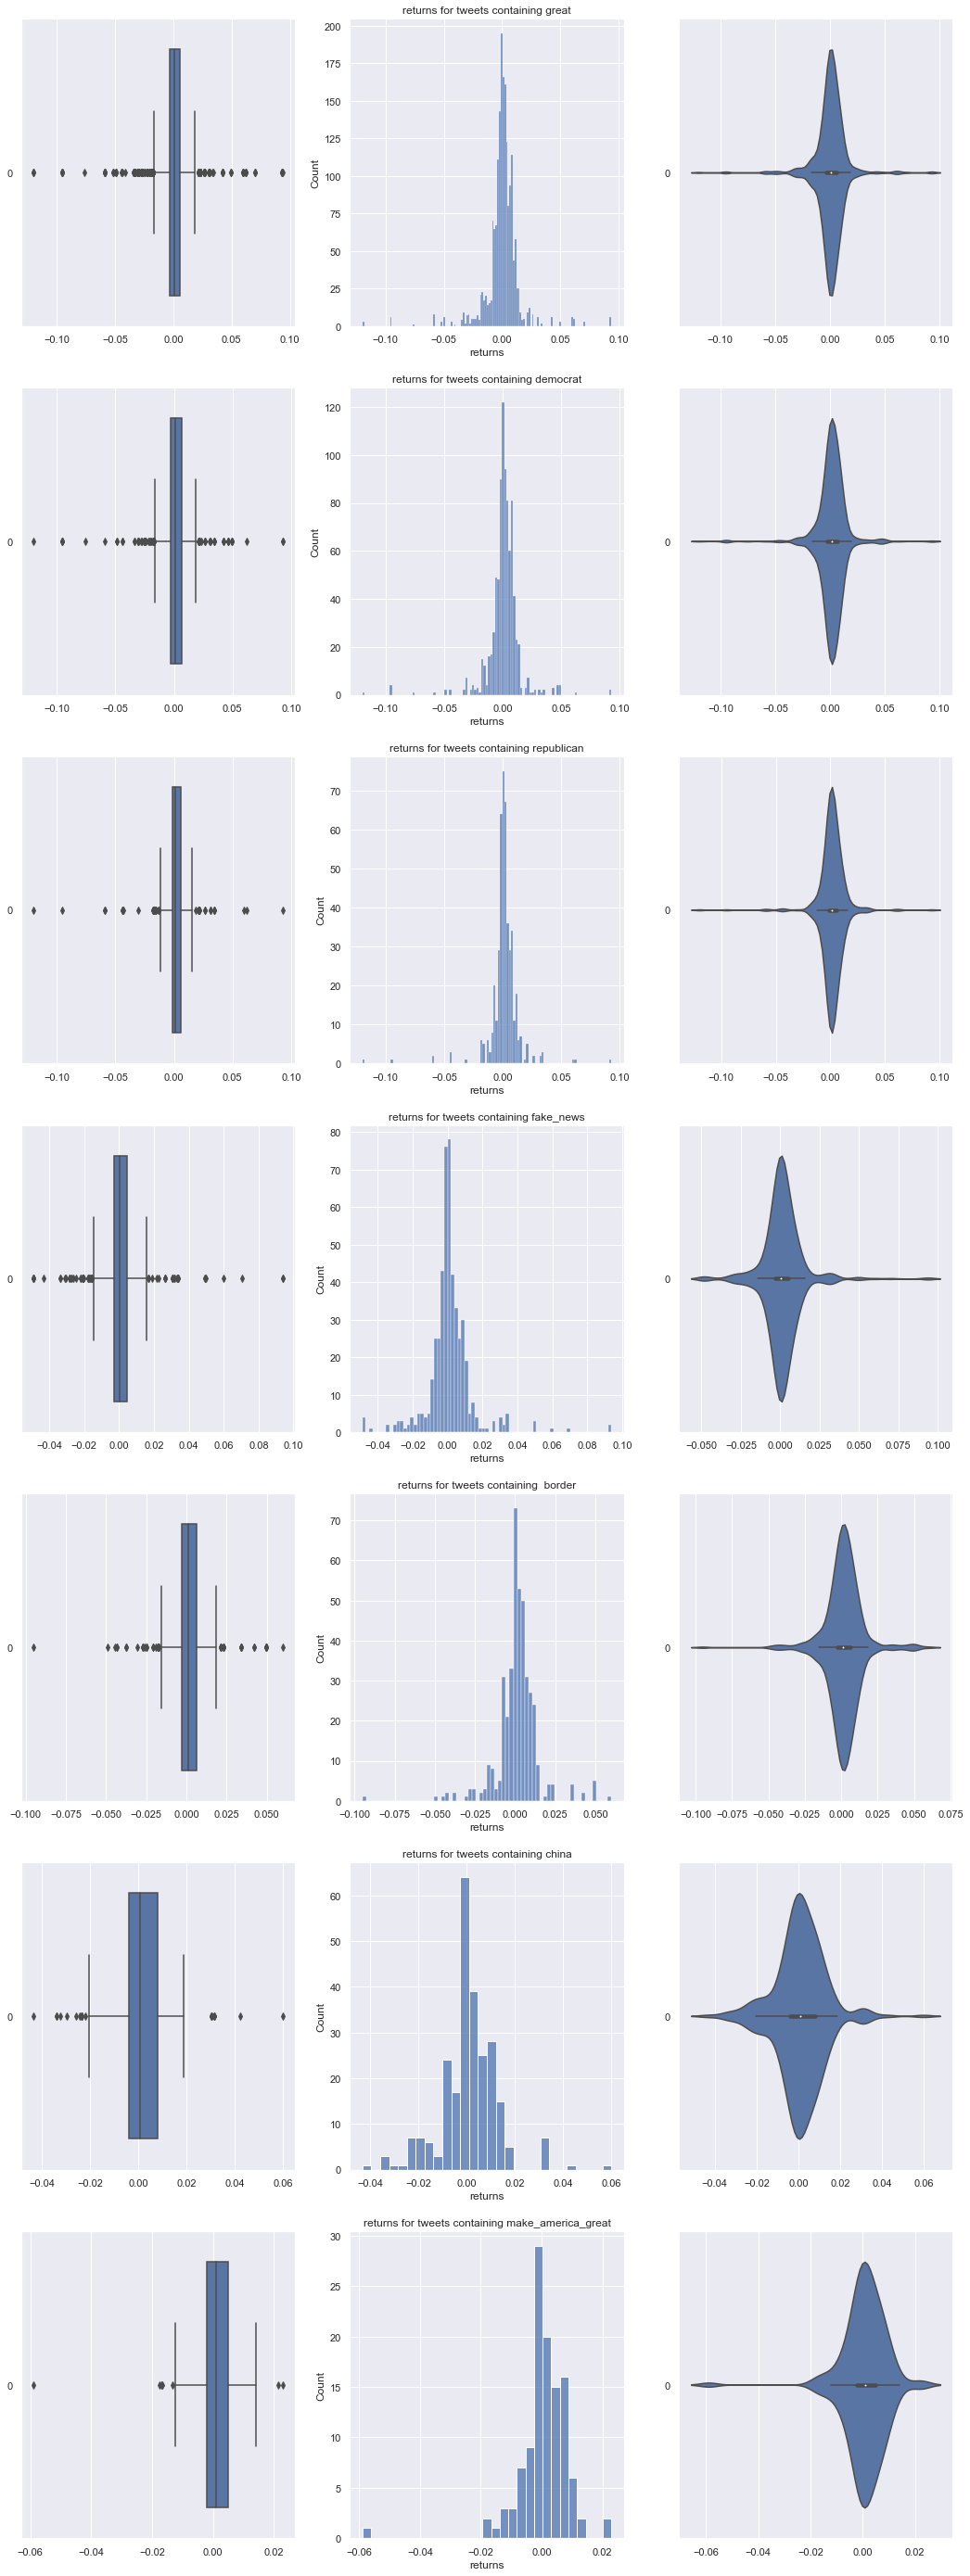

In [87]:
f, axes = plt.subplots(7, 3, figsize=(18, 50))
count = 0
for word in wordlist:
    data = P[P['single'].str.contains(word)]
    sb.boxplot(data = data['returns'], orient = "h", ax = axes[count,0])
    sb.histplot(data = data['returns'], ax = axes[count,1]).set(title=("returns for tweets containing "+ word))
    sb.violinplot(data = data['returns'], orient = "h", ax = axes[count,2])
    count += 1

# Analysis
The performance of S&P500 remains a relatively normal distribution despite being split up by the words they contain. This suggest that ther is no correlationship between words in the tweet and market performance. Let us perform Linear Regression to access further.

Intercept of Regression 	: b =  -0.06052476075516791
Coefficients of Regression 	: a =  [-0.14170728  0.70522776  1.3852349   1.33686655  0.71149389  0.85342759
  0.85422949]

           Predictors  Coefficients
0               great     -0.141707
1            democrat      0.705228
2          republican      1.385235
3           fake_news      1.336867
4              border      0.711494
5               china      0.853428
6  make_america_great      0.854229



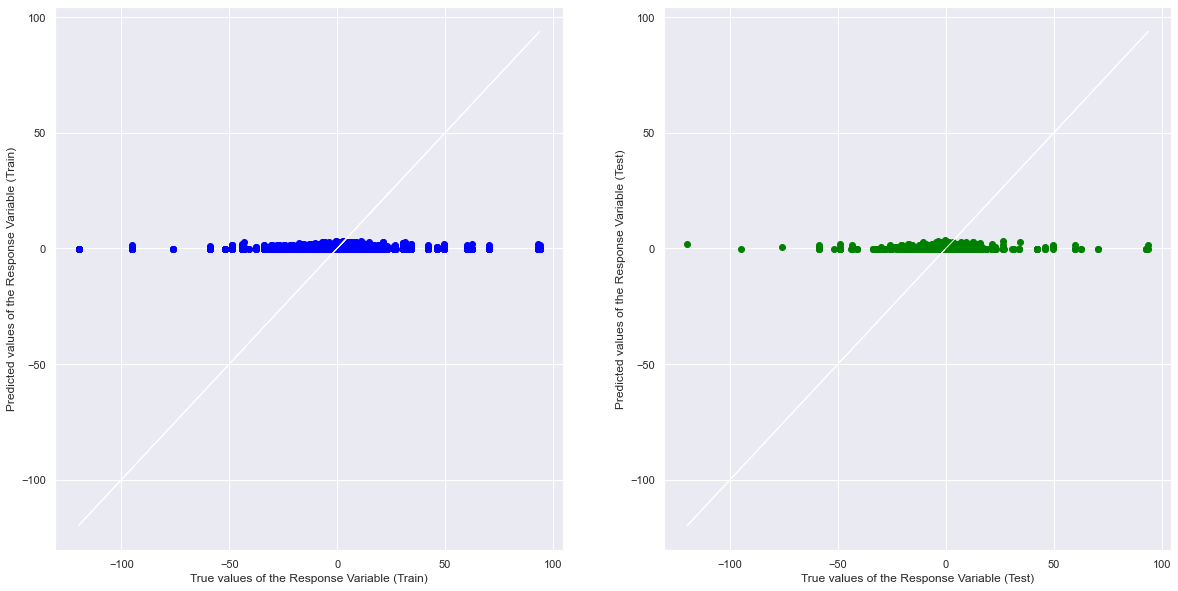

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0014539730050818767
Mean Squared Error (MSE) 	: 236.25507411866604

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0012492992888566423
Mean Squared Error (MSE) 	: 200.40818343016173



In [91]:
# Split the Dataset into Train and Test
x_train, x_test, y_train, y_test = train_test_split(P, P['returns'], test_size = 0.2, random_state=42)

x_train3 = x_train[['great', 'democrat', 'republican', 'fake_news', ' border', 'china', 'make_america_great']]
x_test3 = x_test[['great', 'democrat', 'republican', 'fake_news', ' border', 'china', 'make_america_great']]

# Linear Regression using Train Data
linreg = LinearRegression()        
linreg.fit(x_train3, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(x_train3.columns, linreg.coef_)), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(x_train3)
y_test_pred = linreg.predict(x_test3)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_train3, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_test3, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [93]:
P = P.drop(['great', 'democrat', 'republican', 'fake_news', ' border', 'china', 'make_america_great'], axis = 1)

### LinReg with the topics related to by the tweet of Donald Trump

In [43]:
#returns the percentage of each topic that each tweet belongs to
train_vecs = []
for i in range(len(P)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(34)]
    train_vecs.append(topic_vec)
    
train_vecs

[[0.00040221727,
  0.022567088,
  0.019922484,
  0.03364394,
  0.024577457,
  0.026556361,
  0.0094826305,
  0.035214163,
  0.030143123,
  0.009513406,
  0.05772351,
  0.08120777,
  0.017517477,
  0.007468454,
  0.020709015,
  0.010791735,
  0.02793955,
  0.022715306,
  0.019906137,
  0.025263917,
  0.029457998,
  0.011594266,
  0.008592266,
  0.055606764,
  0.006117828,
  0.026275612,
  0.032677837,
  0.037248302,
  0.0666096,
  0.09826934,
  0.015879093,
  0.00054767495,
  0.06774824,
  0.040109448],
 [0.00030555952,
  0.07732303,
  0.015134866,
  0.025558887,
  0.018671194,
  0.020174542,
  0.007203838,
  0.026751768,
  0.08309785,
  0.0072272182,
  0.013754513,
  0.1218933,
  0.013307813,
  0.005673693,
  0.015732385,
  0.038295235,
  0.021225333,
  0.01725654,
  0.015122449,
  0.019192686,
  0.02237888,
  0.008808021,
  0.0065274388,
  0.012143907,
  0.004647639,
  0.01996126,
  0.054923892,
  0.118134476,
  0.050599072,
  0.044555224,
  0.012063152,
  0.00041606196,
  0.02136787,

In [94]:
#Assigning the top 3 topics related to each tweet

P['Topic 1'] = -1
P['Topic 2'] = -1
P['Topic 3'] = -1
top_3 =[]
for i in range(len(P)):
    top_topics = (lda_model.get_document_topics(corpus[i], minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(34)]
    a = np.array(topic_vec)
    temp = np.argpartition(a, -3)[-3:]
    temp = temp[::-1].tolist()
    top_3.append(temp)
    P.iloc[i, P.columns.get_loc('Topic 1')] = temp[0]+1
    P.iloc[i, P.columns.get_loc('Topic 2')] = temp[1]+1
    P.iloc[i, P.columns.get_loc('Topic 3')] = temp[2]+1
P

,content,retweets,favorites,mentions,hashtags,Volume,returns,wordCount,single,Topic 1,Topic 2,Topic 3
date,,,,,,,,,,,,
2017-01-22,a fantastic day and evening in washington dcth...,19831,158502,@FoxNews,NaN,3.152710e+09,-2.690125,23,fantast day washington_dcthank mani news outle...,30,12,33
2017-01-23,had a great meeting at cia headquarters yester...,14153,113013,NaN,NaN,3.810960e+09,6.564594,21,great meet cia headquart yesterday pack hous p...,28,12,9
2017-01-23,watched protests yesterday but was under the i...,38039,186835,NaN,NaN,3.810960e+09,6.564594,23,watch protest yesterday impress elect didnt pe...,9,12,28
2017-01-23,wow television ratings just out 31 million peo...,33675,192297,NaN,NaN,3.810960e+09,6.564594,23,wow televis rate 31 million peopl watch inaugu...,28,12,27
2017-01-23,peaceful protests are a hallmark of our democr...,76233,353955,NaN,NaN,3.810960e+09,6.564594,24,peac protest hallmark democraci dont alway agr...,31,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-15,,26394,109146,NaN,NaN,5.829240e+09,18.962398,1,,12,34,28
2020-06-15,does anyone notice how little the radical left...,50321,201626,NaN,NaN,5.829240e+09,18.962398,47,anyon notic littl radic left takeov seattl dis...,9,3,30
2020-06-15,interesting how antifa and other far left mili...,69353,268924,NaN,NaN,5.829240e+09,18.962398,48,antifa far left milit group citi bare wimpier ...,12,34,8


Intercept of Regression 	: b =  0.46150239079909805
Coefficients of Regression 	: a =  [-0.00575108  0.02293341 -0.02703758]

  Predictors  Coefficients
0    Topic 1     -0.005751
1    Topic 2      0.022933
2    Topic 3     -0.027038



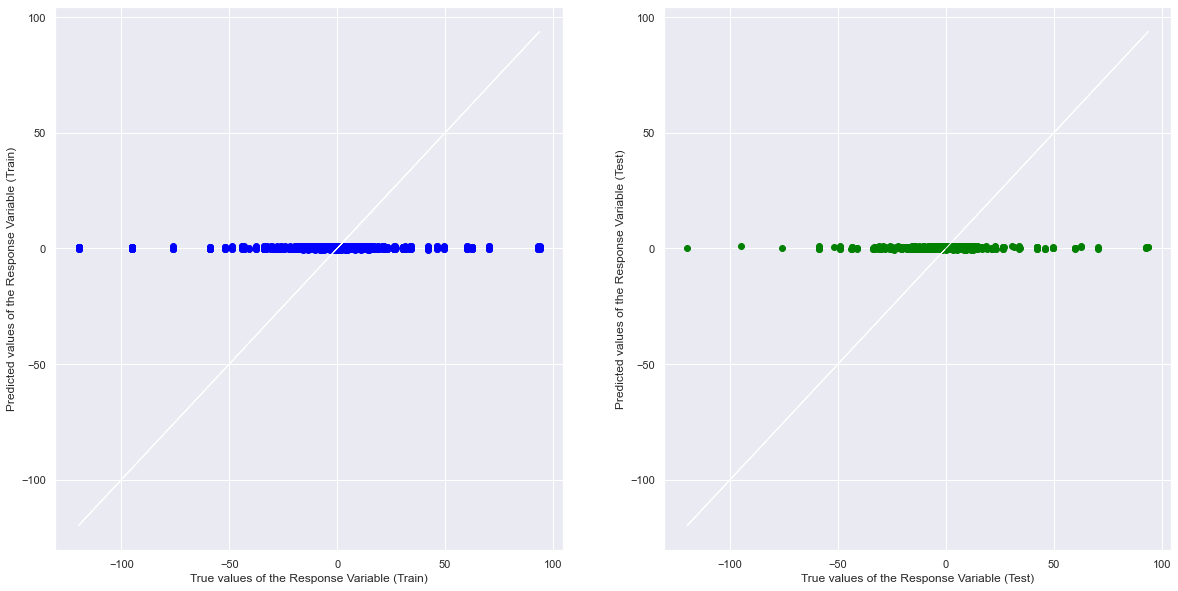

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0006284404459832027
Mean Squared Error (MSE) 	: 236.45039436496876

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0009217815586755052
Mean Squared Error (MSE) 	: 200.3426280950485



In [95]:
# Split the Dataset into Train and Test
x_train, x_test, y_train, y_test = train_test_split(P, P['returns'], test_size = 0.2, random_state=42)

x_train3 = x_train[['Topic 1', 'Topic 2', 'Topic 3']]
x_test3 = x_test[['Topic 1', 'Topic 2', 'Topic 3']]

# Linear Regression using Train Data
linreg = LinearRegression()        
linreg.fit(x_train3, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(x_train3.columns, linreg.coef_)), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(x_train3)
y_test_pred = linreg.predict(x_test3)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_train3, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_test3, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Analysis
The performance(indicated by returns) does not seem to be correlated to either words or topics of the tweets posted by Donald Trump during his presidency period, as both LinReg model has very high MSE.